In [1]:
# default_exp standard_themes/saw_multiclass

In [2]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Tritonlytics Multilabel Classification - Standard S@W Themes

> Models to predict what standard themes a verbatim belongs too

In [3]:
#export
import datetime
import sklearn.metrics as skm
from tritonlytics_ai.utils import *

from fastai import __version__ as fa2_version
from fastai.text.all import *

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import spacy
spacy_en = spacy.load('en_core_web_sm')
spacy_es = spacy.load('es_core_news_sm')

In [4]:
#hide
import pdb, gc

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [5]:
#hide
print(f'fastai version: {fa2_version}')

fastai version: 2.0.16


In [6]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Data

Basic Configuration

In [7]:
#export
vocab = pickle.load(open(LM_PATH/'vocab.pkl', 'rb')); len(vocab)

32408

In [8]:
bsz = 80
bptt= 72
wd = 1e-7

In [9]:
chunksize = 24000

include_fld_tok = False
include_bos_tok = True
include_eos_tok = False

In [10]:
# define what text columns to use (can be multiple)
corpus_cols = ['answer_text'] 

# define how to identify the text we are using for the LM
corpus_suf = '' #'_cleaned'

Prepare the data source

In [11]:
STANDARD_THEME_SAW_LABELS

['adequate_staffing',
 'advancement_and_training_opportunities',
 'appropriate_stress_work_assigned_equitably',
 'benefits',
 'better_ways_recognized_participate_in_decisions',
 'career_advancement',
 'committed_to_diversity',
 'communicates_essential_information',
 'ethical_conduct_perform_responsibilities_spirit_of_cooperation',
 'evaluated_fairly',
 'experienced_discrimination',
 'facilities_workspace_safety',
 'faculty_value_contributions',
 'favoritism_cliques',
 'fear_of_retaliation_negative_consequences',
 'feel_valued_by_department',
 'flexibility_work_life_balance',
 'good_use_of_skills',
 'have_necessary_tools',
 'have_voice_within_my_institution_valued_member_of_my_institution',
 'internal_processes_effective',
 'parking_transportation',
 'salary_pay',
 'satisfied_with_diversity_progams',
 'supervisor_effectiveness_resolves_staff_issues']

In [307]:
y_label = 'adequate_staffing'

In [308]:
train_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'train.csv')
valid_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'test.csv')

Remove any rows whre the "corpus_cols" are nan

In [309]:
train_df.dropna(subset=corpus_cols, inplace=True)
valid_df.dropna(subset=corpus_cols, inplace=True)

In [310]:
train_df['is_valid'] = False
valid_df['is_valid'] = True
df = pd.concat([train_df, valid_df])

Fetch the label's value distribution and calculate the positive/negative ratio

In [311]:
label_dist = train_df[y_label].value_counts()

In [312]:
pos_ratio = label_dist[0] / label_dist[1]; pos_ratio

9.767123287671232

Create a over/undersampled df

In [313]:
if (pos_ratio > 6.75):
    oversample = RandomOverSampler(sampling_strategy=0.5)
    train_df, _ = oversample.fit_sample(train_df, train_df[y_label])

    # undersample = RandomUnderSampler(sampling_strategy=0.5)
    # train_df, _ = undersample.fit_sample(train_df, train_df[y_label])

    df = pd.concat([train_df, valid_df])

In [314]:
train_df[y_label].value_counts()

0    2852
1    1426
Name: adequate_staffing, dtype: int64

Setup DataBlock

In [315]:
# prepend custom tokenization rules to defaults
custom_lowercase = partial(lowercase, add_bos=include_bos_tok, add_eos=include_eos_tok)

custom_tok_rules = defaults.text_proc_rules[:-1] + [custom_lowercase, 
                                                    make_replacements, 
                                                    fix_ampm, 
                                                    fix_sentence_ends, 
                                                    fix_hyphenated_words]

In [316]:
%%time

blocks = (
    TextBlock.from_df(corpus_cols, vocab=vocab, seq_len=bptt, rules=custom_tok_rules, mark_fields=include_fld_tok),
    CategoryBlock()
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'),
                   get_y=ColReader(y_label),
                   splitter=ColSplitter(col='is_valid'))

CPU times: user 130 ms, sys: 161 µs, total: 130 ms
Wall time: 129 ms


In [317]:
# dblock.summary(df)

In [318]:
%%time
dls = dblock.dataloaders(df, bs=bsz, seq_len=bptt)

CPU times: user 4.19 s, sys: 677 ms, total: 4.86 s
Wall time: 5.23 s


In [319]:
len(dls.train_ds), len(dls.valid_ds), dls.vocab[1]

(4278, 350, (#2) [0,1])

In [320]:
print((
    f'The Datasets vocab has {len(dls.vocab)} items : the inputs vocab ({len(dls.vocab[0])} items), '
    f'and the targets ({len(dls.vocab[1])} items)'))

The Datasets vocab has 2 items : the inputs vocab (32408 items), and the targets (2 items)


In [321]:
print(dls.train_ds[21])

(TensorText([    2,     8,    44,    15,   348,  1294,   309,    68,  8544,   339,
         3614,    10,  1595,  4626,    11,    79,   339,    12,   352,    51,
           18,    74,    95,    16,    10,  2230,   180,    29,  1674,    68,
        21272,    68,  6488,    33,     9,     8,    49,    23,    15,    70,
          154,  2091,    29,   113,  3140,    18,    12,    80,    17,    74,
           95,    12,  1567,    58,    70,   339,   356,    28,   359,    58,
           11,    62,  1088,     9,     8,   327,    13,   266,    15,   736,
           11,    22,   588,    16,  1927,    13,   615,    13,    12,  2360,
           78,  1044,   664,    51,    19,    59,     9,     8,  1567,  1941,
           84,    10,  1934,  2674,    10,   195,    17,   266,    62,  1088,
           12,   266,  5469,    17,   710,     9,     8,    28,   235,    58,
          725,   398,    11,   117,    69,  1088,    12,    14,    36,    39,
           23,    10,  1742,    14,    73,    47,    28,   

In [322]:
dls.show_batch(max_n=2)

,text,category
0,"xxbos xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj university of xxmaj california gives them and exercise nepotism because",0
1,"xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos xxmaj insights as alumna / former student of xxup ucsd , working on main campus 3.5 + years , mexican - american female & varied experience from start - up to non - profit to corporate : \ r \n 1 . xxmaj dept / culture : all , not just leadership / xxup hr- trained yearly on effective leadership , diversity / inclusivity , utilizing technology & innovative ideas on team dynamics / future of work",0


In [323]:
batch = next(iter(dls.train))
print(batch[0].size(), batch[0].type(), batch[1].size(), batch[1].type(), bsz)

torch.Size([80, 467]) torch.cuda.LongTensor torch.Size([80]) torch.cuda.LongTensor 80


In [324]:
' '.join([ dls.vocab[0][idx] for idx in batch[0][0,:] ])

"xxbos xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj university of xxmaj california gives them and exercise nepotism because they are both product of such practices . \\ r \n 

Save the `Dataloaders` object for future use

In [325]:
# save dataloaders
torch.save(dls, STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw_multiclass.pkl')
# dls = torch.load(STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw_multiclass.pkl')

## Training

Configure a forward or backwards run

In [326]:
backwards = False
m_suf = '_multiclass' #'_cleaned'
m_pre = 'bwd_' if (backwards) else 'fwd_'

dls = torch.load(STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw_multiclass.pkl')
if (backwards): dls.tfms.append(Transform(reverse_text))

In [327]:
# copied from /lm/models -> class/models (both fwd and bwd weights)
! cp {LM_PATH/'models/*_lm_enc.pth'} {STANDARD_THEME_SAW_PATH/'models/'}  

Configure our metrics

In [328]:
# define metrics
beta, start, end, average, sample_weight = 0.5, 0.08, 0.7, 'weighted', None

# standard
fbeta_metric = FBeta(beta=beta, average=average, sample_weight=sample_weight, labels=[1])
prec_metric = Precision(average=average, sample_weight=sample_weight, labels=[1])
recall_metric = Recall(average=average, sample_weight=sample_weight, labels=[1])
roc_auc_metric = RocAucBinary(average=average, sample_weight=sample_weight)
ap_score_metric = APScoreBinary(average=average, sample_weight=sample_weight)
bal_acc_metric = BalancedAccuracy(sample_weight=sample_weight)

Configure our loss

In [329]:
label_counts = train_df[y_label].value_counts()
pos_weight = (label_counts[0] / label_counts[1]); pos_weight
pos_weight_vec = [1., (label_counts[0] / label_counts[1]) * 1.0]; pos_weight_vec

[1.0, 2.0]

In [330]:
# loss_func = torch.nn.CrossEntropyLoss(weight=tensor(pos_weight_vec, device=torch.cuda.current_device()))
loss_func = CrossEntropyLossFlat(weight=tensor(pos_weight_vec, device=torch.cuda.current_device()))
# loss_func = LabelSmoothingCrossEntropyFlat(weight=tensor(pos_weight_vec, device=torch.cuda.current_device()))
# loss_func = LabelSmoothingCrossEntropyFlat()

Configure learner

In [331]:
# define callbacks
best_model_cb = SaveModelCallback(monitor='average_precision_score', 
                                  comp=np.greater, 
                                  reset_on_fit=False,
                                  fname=f'{m_pre}cls_bestmodel{m_suf}')

In [332]:
learn_cbs = []
fit_cbs = [best_model_cb]

learn_metrics = [ accuracy, bal_acc_metric, ap_score_metric, fbeta_metric, prec_metric, recall_metric, roc_auc_metric]

# build learner
learn = text_classifier_learner(dls, 
                                AWD_LSTM, 
                                pretrained=False,
                                alpha=2.0, beta=1.0,      # default - alpha=2.0, beta=1.0
                                moms=(0.95, 0.85, 0.95),  # default - (0.95, 0.85, 0.95)
                                wd=wd,                    # default - None
                                seq_len=bptt,             # default - 72
                                drop_mult=0.7,            # default - 0.5
                                lin_ftrs=[50],            # default - [50]
                                ps=[0.1],                 # default - [0.1]
                                metrics=learn_metrics, 
                                loss_func=loss_func,
                                cbs=learn_cbs,
                                path=STANDARD_THEME_SAW_PATH)

learn.opt = learn.create_opt()

In [333]:
# learn.summary()

In [334]:
# learn.show_training_loop()

In [335]:
learn = learn.load_encoder(f'{m_pre}lm_enc')

In [336]:
best_model_path = STANDARD_THEME_SAW_PATH/f'models/{m_pre}cls_bestmodel{m_suf}*'
if (best_model_path.exists()): best_model_path.unlink(missing_ok=False)

Train

In [337]:
1e-1, 0.017378008365631102/10, 2e-1

(0.1, 0.0017378008365631103, 0.2)

(0.03019951581954956, 0.17378008365631104)

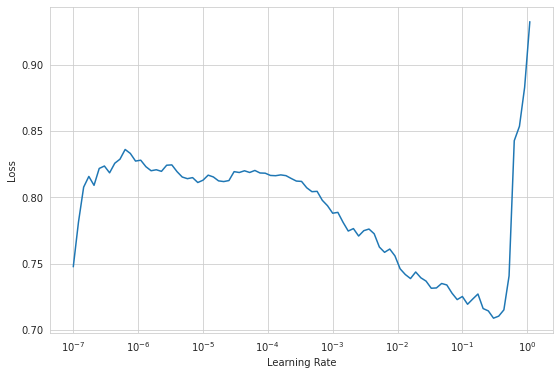

In [338]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [339]:
lr= lr_min # note: lr_min = min/10!

In [340]:
learn.fit_one_cycle(1, lr_max=lr, cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,average_precision_score,fbeta_score,precision_score,recall_score,roc_auc_score,time
0,0.659652,0.632776,0.591429,0.694993,0.347886,0.201729,0.169697,0.823529,0.776340,00:06


Better model found at epoch 0 with average_precision_score value: 0.34788568580923834.


In [341]:
learn.save(f'{m_pre}cls_last_ft{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_last_ft_multiclass.pth')

In [342]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, lr_max=slice(lr/(2.6**4), lr), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,average_precision_score,fbeta_score,precision_score,recall_score,roc_auc_score,time
0,0.567599,0.334137,0.865714,0.755026,0.581221,0.413386,0.381818,0.617647,0.857409,00:06


Better model found at epoch 0 with average_precision_score value: 0.5812207840044004.


In [343]:
learn.save(f'{m_pre}cls_last2_ft{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_last2_ft_multiclass.pth')

In [344]:
learn.freeze_to(-3)
lr = lr/3
learn.fit_one_cycle(1, lr_max=slice(lr/(2.6**4),lr), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,average_precision_score,fbeta_score,precision_score,recall_score,roc_auc_score,time
0,0.466767,0.337561,0.845714,0.783321,0.530426,0.392157,0.352941,0.705882,0.851080,00:09


In [345]:
learn.save(f'{m_pre}cls_last3_ft{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_last3_ft_multiclass.pth')

In [346]:
learn.unfreeze()
lr = lr/10
learn.fit_one_cycle(10, lr_max=slice(lr/(2.6**4),lr), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,average_precision_score,fbeta_score,precision_score,recall_score,roc_auc_score,time
0,0.477834,0.312411,0.865714,0.728779,0.574497,0.399160,0.372549,0.558824,0.854523,00:12
1,0.456684,0.288891,0.877143,0.761355,0.574161,0.441176,0.411765,0.617647,0.859922,00:12
2,0.403913,0.268902,0.891429,0.743019,0.537280,0.470297,0.452381,0.558824,0.848194,00:12
3,0.355392,0.269069,0.891429,0.769267,0.523171,0.481651,0.456522,0.617647,0.854989,00:12
4,0.298033,0.253928,0.902857,0.762472,0.544631,0.515464,0.500000,0.588235,0.869509,00:12
5,0.248281,0.269569,0.885714,0.779226,0.531935,0.470085,0.440000,0.647059,0.862993,00:12
6,0.223492,0.260461,0.908571,0.739389,0.539791,0.529412,0.529412,0.529412,0.862807,00:12
7,0.201367,0.267706,0.908571,0.778760,0.539889,0.541237,0.525000,0.617647,0.864762,00:12
8,0.195040,0.272031,0.902857,0.775596,0.544239,0.519802,0.500000,0.617647,0.865227,00:12
9,0.180188,0.273116,0.897143,0.772431,0.538773,0.500000,0.477273,0.617647,0.863645,00:12


In [347]:
learn.save(f'{m_pre}cls{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_multiclass.pth')

Export model for inference

In [348]:
learn.export(fname=f'{m_pre}export_clas{m_suf}.pkl')

Look at results

In [349]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [350]:
scores = dict(zip(learn.recorder.metric_names[2:], learn.validate())); scores

{'valid_loss': 0.3341374099254608,
 'accuracy': 0.8657143115997314,
 'balanced_accuracy_score': 0.7550260610573343,
 'average_precision_score': 0.5812207840044004,
 'fbeta_score': 0.41338582677165353,
 'precision_score': 0.38181818181818183,
 'recall_score': 0.6176470588235294,
 'roc_auc_score': 0.8574087862993298}

In [351]:
# 3
# LabelSmoothingCrossEntropyFlat (weighted)
# {'valid_loss': 0.37808558344841003,
#  'accuracy': 0.8999999761581421,
#  'balanced_accuracy_score': 0.7083953834698437,
#  'average_precision_score': 0.523870336738839,
#  'fbeta_score': 0.48192771084337355,
#  'precision_score': 0.48484848484848486,
#  'recall_score': 0.47058823529411764,
#  'roc_auc_score': 0.8494973938942666}

# 4
# LabelSmoothingCrossEntropyFlat (non-weighted)
# {'valid_loss': 0.3847247362136841,
#  'accuracy': 0.8828571438789368,
#  'balanced_accuracy_score': 0.7382725241995532,
#  'average_precision_score': 0.501081364104716,
#  'fbeta_score': 0.44392523364485986,
#  'precision_score': 0.4222222222222222,
#  'recall_score': 0.5588235294117647,
#  'roc_auc_score': 0.861783320923306}


# 1
# CrossEntropyFlat (weighted)
# {'valid_loss': 0.3346174359321594,
#  'accuracy': 0.854285717010498,
#  'balanced_accuracy_score': 0.7880677587490692,
#  'average_precision_score': 0.5324929100754646,
#  'fbeta_score': 0.4081632653061225,
#  'precision_score': 0.36923076923076925,
#  'recall_score': 0.7058823529411765,
#  'roc_auc_score': 0.8854244229337305}

# 2
# CrossEntropyFlat (non-weighted)
# {'valid_loss': 0.29955244064331055,
#  'accuracy': 0.8857142925262451,
#  'balanced_accuracy_score': 0.7529784065524945,
#  'average_precision_score': 0.5246925524959257,
#  'fbeta_score': 0.4587155963302752,
#  'precision_score': 0.43478260869565216,
#  'recall_score': 0.5882352941176471,
#  'roc_auc_score': 0.8596425912137007}

In [352]:
learn.show_results(max_n=4, trunc_at=60)

,text,category,category_
0,"xxbos i work at xxup shs . xxmaj we have been bullied into going onto xxup ucsd xxup hs ' xxmaj epic xxup emr by the xxup hs xxup ceo / xxup cio . xxmaj epic is wrong for this clinic . xxmaj the xxup emr we currently use , xxmaj point and xxmaj click ( pnc ) , is",0,0
1,"xxbos i have been working for over 25 years – in some of the largest , most respected , and influential organizations in xxmaj america . \ r \n i have never faced such levels of discrimination , racism , harassment , bullying , intimidation – as i have in xxup ucsd xxmaj housing and xxmaj dining xxmaj department .",0,0
2,"xxbos 1 ) i am a lab manager in the cognitive science department who is officially for employment purposes a "" lab associate "" . i think this is wrong because there are several things a lab manager should be trained on that i did not have access to train on because i am not technically a "" lab manager",1,0
3,xxbos xxmaj the work environment in our department would be better if there were not so much nepotism . xxmaj my direct supervisor hired her best friend ; no one in the department was involved with the interview process for her hiring . xxmaj we were completely kept in the dark . xxmaj although most of us in the department,1,0


In [353]:
interp = ClassificationInterpretation.from_learner(learn)

In [354]:
interp.confusion_matrix()

array([[282,  34],
       [ 13,  21]])

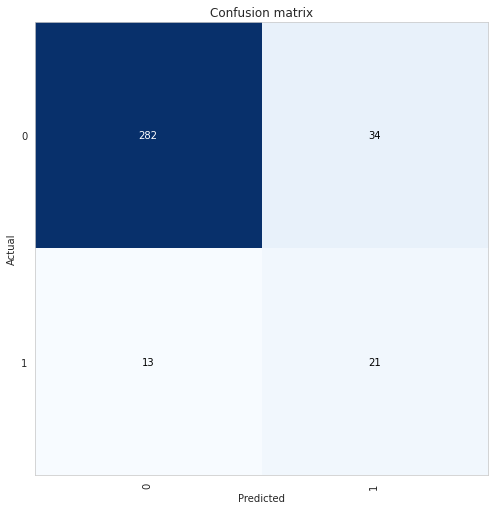

In [355]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [356]:
interp.plot_top_losses(k=5)

,input,target,predicted,probability,loss
0,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos xxmaj there seems to be,1,0,0.9516710042953491,3.0297234058380127
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,1,0,0.9226167798042297,2.558985471725464
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,1,0,0.8197781443595886,1.7135668992996216
3,"xxbos 1 ) i am a lab manager in the cognitive science department who is officially for employment purposes a "" lab associate "" . i think this is wrong because there are several things a lab manager should be trained on that i did not have access to train on because i am not technically a "" lab manager "" ( e. g . , i had no training on xxup hrpp ) . xxmaj this also means that my department can pay me way less than a lab manager even though i take care of xxup everything in the lab and basically run it . \ r \n 2 ) xxmaj my department is not inclusive . i was told something that was culturally insensitive by a graduate student , but when i reported it to my supervisor there were no repercussions for this student . \ r",1,0,0.7487717270851135,1.3813931941986084
4,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xx

Use it for inference

In [357]:
inf_learn = load_learner(STANDARD_THEME_SAW_PATH/f'{m_pre}export_clas{m_suf}.pkl')

In [358]:
inf_learn.predict('We have plenty of staff to help us although more would be great!!!', with_input=True)

('xxbos xxmaj we have plenty of staff to help us although more would be great xxrep 3 !',
 '1',
 tensor(1),
 tensor([0.3030, 0.6970]))

Review final validation loss for best model

In [359]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [360]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

Validation Loss: 0.3341374695301056


In [361]:
learn.predict("the medical insurance is too expensive")

('0', tensor(0), tensor([0.9629, 0.0371]))

In [362]:
learn.predict("I like cats")

('0', tensor(0), tensor([0.9651, 0.0349]))

## Review

### Lets look at validation metrics

In [363]:
# predictions for a single model using the learner's model and data loaders
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
learn.model.cuda(1)
raw_inputs, probs, targs, losses= learn.get_preds(with_input=True, with_loss=True)

len(raw_inputs), probs.shape, targs.shape, len(dls.valid_ds), dls.c

(350, torch.Size([350, 2]), torch.Size([350]), 350, 2)

In [364]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.08, end=.7, sigmoid=False, 
                                   average=average, sample_weight=sample_weight, labels=[1])
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.08, end=.7, sigmoid=False, 
                                   average=average, sample_weight=sample_weight, labels=[1])
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.08, end=.7, sigmoid=False, 
                                   average=average, sample_weight=sample_weight, labels=[1])

In [365]:
targs.shape

torch.Size([350])

In [366]:
threshold_f05 = f05.opt_th(probs[:,1], targs)
threshold_f1 = f1.opt_th(probs[:,1], targs)
threshold_f2 = f2.opt_th(probs[:,1], targs)

threshold_f05, threshold_f1, threshold_f2

(0.6799999999999996, 0.6399999999999997, 0.3099999999999999)

In [367]:
f05_score = f05.opt_fscore(probs[:,1], targs)
f1_score = f1.opt_fscore(probs[:,1], targs)
f2_score = f2.opt_fscore(probs[:,1], targs)

f05_score, f1_score, f2_score

(0.6666666666666666, 0.5185185185185185, 0.5870445344129553)

In [368]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs[:,1] > threshold_f05), beta=1, 
                      average=average, sample_weight=sample_weight, zero_division=False, labels=[1])
res

0.5

In [369]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs[:,1], targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs[:,1], targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs[:,1], targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9314285516738892, 0.9257143139839172, 0.7514285445213318)

In [370]:
# make sure we are getting the same f1 accuracy
preds = ((probs[:,1] > threshold_f05).byte() == targs.byte()).float().mean()
preds.item()

0.9314285516738892

### Overall metrics

In [371]:
eval_targs = targs
eval_probs = probs[:,1]

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [372]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f05).float(), 
                         sample_weight=sample_weight))

0.9314285714285714


In [373]:
bal_acc_metric((eval_probs > threshold_f05).float(),eval_targs)

0.6733060312732688

In [374]:
ap_score_metric(eval_probs,eval_targs)

0.5812207840044004

#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [375]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0 316


In [376]:
most_freq_class_count / len(eval_targs)

0.9028571428571428

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [377]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f05).float(), 
                            weights=None, sample_weight=sample_weight))

0.46996466431095407


#### Confusion Matrix

Describes the performance of a classification model

In [378]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [379]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight)

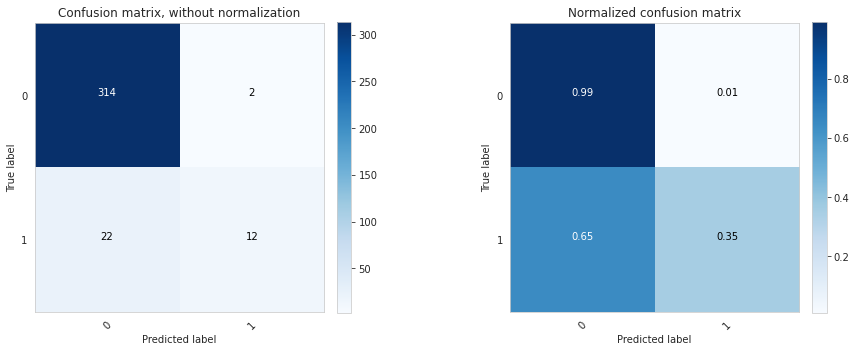

In [380]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [381]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f05).float(), labels=[0,1], 
                                sample_weight=sample_weight))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       316
           1       0.86      0.35      0.50        34

    accuracy                           0.93       350
   macro avg       0.90      0.67      0.73       350
weighted avg       0.93      0.93      0.92       350



#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

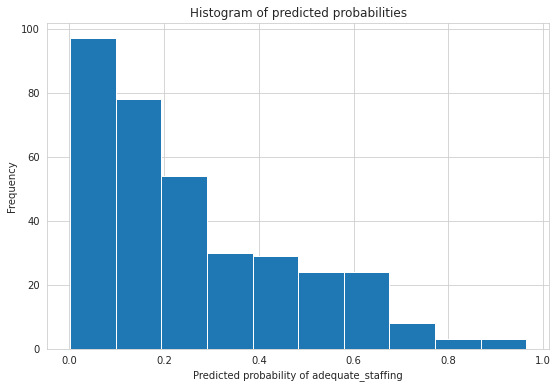

In [382]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel(f'Predicted probability of {y_label}')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [383]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

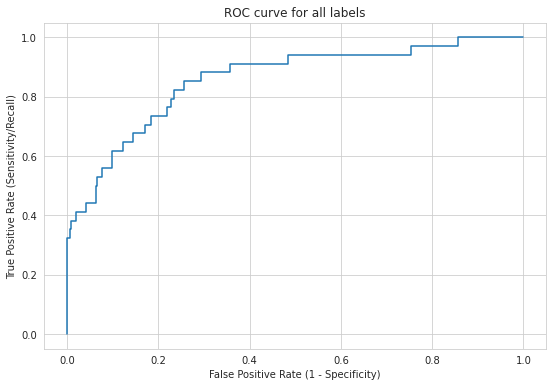

In [384]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [385]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

0.8574087862993298


## Multiclass Training Loop

In [73]:
try:
    learn.purge(); learn = None;
    gc.collect()
    torch.cuda.empty_cache()
except: pass

In [74]:
#export
bsz = 80
bptt= 72
wd = 1e-7

chunksize = 24000

include_fld_tok = False
include_bos_tok = True
include_eos_tok = False

# define what text columns to use (can be multiple)
corpus_cols = ['answer_text'] 

# define how to identify the text we are using for the LM
corpus_suf = '' #'_cleaned'

# copied from /lm/models -> class/models (both fwd and bwd weights)
! cp {LM_PATH/'models/*_lm_enc.pth'} {STANDARD_THEME_SAW_PATH/'models/'} 

In [75]:
#export
# configure metrics
beta, start, end, average, sample_weight = 0.5, 0.08, 0.7, 'weighted', None

# standard
fbeta_metric = FBeta(beta=beta, average=average, sample_weight=sample_weight, labels=[1])
prec_metric = Precision(average=average, sample_weight=sample_weight, labels=[1])
recall_metric = Recall(average=average, sample_weight=sample_weight, labels=[1])
roc_auc_metric = RocAucBinary(average=average, sample_weight=sample_weight)
ap_score_metric = APScoreBinary(average=average, sample_weight=sample_weight)
bal_acc_metric = BalancedAccuracy(sample_weight=sample_weight)

# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.08, end=.7, sigmoid=False, 
                                   average=average, sample_weight=sample_weight, labels=[1])
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.08, end=.7, sigmoid=False, 
                                   average=average, sample_weight=sample_weight, labels=[1])
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.08, end=.7, sigmoid=False, 
                                   average=average, sample_weight=sample_weight, labels=[1])

In [76]:
#export 
#configure loss
def get_weighted_loss_func(df, lbl):
    label_counts = df[lbl].value_counts()
    pos_weight = (label_counts[0] / label_counts[1]); pos_weight
    pos_weight_vec = [1., (label_counts[0] / label_counts[1]) * 1.0]; pos_weight_vec

    weighted_loss_func = CrossEntropyLossFlat(weight=tensor(pos_weight_vec, device=torch.cuda.current_device()))
    return weighted_loss_func

In [80]:
#export
def train_saw_themes_multiclass(y_label, reverse_text=False, use_weighted_loss=False):
    
    # ===== TRAINING/VALIDATION DATASETS =====
    
    train_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'train.csv')
    valid_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'test.csv')

    train_df.dropna(subset=corpus_cols, inplace=True)
    valid_df.dropna(subset=corpus_cols, inplace=True)

    train_df['is_valid'] = False
    valid_df['is_valid'] = True
    df = pd.concat([train_df, valid_df])

    label_dist = train_df[y_label].value_counts()
    pos_ratio = label_dist[0] / label_dist[1]; pos_ratio

    if (pos_ratio > 6.75):
        oversample = RandomOverSampler(sampling_strategy=0.5)
        train_df, _ = oversample.fit_sample(train_df, train_df[y_label])
        df = pd.concat([train_df, valid_df])

    # prepend custom tokenization rules to defaults
    custom_lowercase = partial(lowercase, add_bos=include_bos_tok, add_eos=include_eos_tok)

    custom_tok_rules = defaults.text_proc_rules[:-1] + [custom_lowercase, 
                                                        make_replacements, 
                                                        fix_ampm, 
                                                        fix_sentence_ends, 
                                                        fix_hyphenated_words]

    # build datablock
    blocks = (
        TextBlock.from_df(corpus_cols, vocab=vocab, seq_len=bptt, 
                          rules=custom_tok_rules, mark_fields=include_fld_tok),
        CategoryBlock()
    )

    dblock = DataBlock(blocks=blocks, 
                       get_x=ColReader('text'), get_y=ColReader(y_label), 
                       splitter=ColSplitter(col='is_valid'))

    dls = dblock.dataloaders(df, bs=bsz, seq_len=bptt)

    # ===== TRAINING =====

    # configure forward or backwards run
    backwards = reverse_text
    m_suf = f'_multiclass_{y_label}'
    m_pre = 'bwd_' if (backwards) else 'fwd_'
    if (backwards): dls.tfms.append(Transform(reverse_text))

    # define callbacks
    best_model_cb = SaveModelCallback(monitor='average_precision_score', comp=np.greater, reset_on_fit=False,
                                      fname=f'{m_pre}cls_bestmodel{m_suf}')

    opt_thresh_cb = OptimizeFBetaThreshCallback(beta=beta, average=average, sample_weight=sample_weight,
                                                start=start, end=end)

    learn_cbs = [best_model_cb]
    fit_cbs = []

    learn_metrics = [ accuracy, bal_acc_metric, ap_score_metric, 
                     fbeta_metric, prec_metric, recall_metric, roc_auc_metric]

    # build learner
    learn = text_classifier_learner(dls, 
                                    AWD_LSTM, 
                                    pretrained=False,
                                    alpha=2.0, beta=1.0,      # default - alpha=2.0, beta=1.0
                                    moms=(0.95, 0.85, 0.95),  # default - (0.95, 0.85, 0.95)
                                    wd=wd,                    # default - None
                                    seq_len=bptt,             # default - 72
                                    drop_mult=0.7,            # default - 0.5
                                    lin_ftrs=[50],            # default - [50]
                                    ps=[0.1],                 # default - [0.1]
                                    metrics=learn_metrics, 
                                    cbs=learn_cbs,
                                    path=STANDARD_THEME_SAW_PATH)

    learn.opt = learn.create_opt()
    if (use_weighted_loss): learn.loss_func = get_weighted_loss_func(train_df, y_label)

    learn = learn.load_encoder(f'{m_pre}lm_enc')

    best_model_path = STANDARD_THEME_SAW_PATH/f'models/{m_pre}cls_bestmodel{m_suf}*'
    if (best_model_path.exists()): best_model_path.unlink(missing_ok=False)

    lr_min, lr_steep = learn.lr_find()
    lr= lr_min # is already /10

    # fit
    with learn.no_logging(): learn.fit_one_cycle(1, lr_max=lr, cbs=fit_cbs)

    learn.freeze_to(-2)
    with learn.no_logging(): learn.fit_one_cycle(1, lr_max=slice(lr/(2.6**4), lr), cbs=fit_cbs)

    learn.freeze_to(-3)
    lr = lr/3
    with learn.no_logging(): learn.fit_one_cycle(1, lr_max=slice(lr/(2.6**4), lr), cbs=fit_cbs)

    learn.unfreeze()
    lr = lr/10
    with learn.no_logging(): learn.fit_one_cycle(10, lr_max=slice(lr/(2.6**4), lr), cbs=fit_cbs)

    learn.export(fname=f'{m_pre}export_clas{m_suf}.pkl')

    # ===== RETURN SCORES =====
    
    learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
    scores = dict(zip(learn.recorder.metric_names[2:], learn.validate()))
    probs, targs, losses = learn.get_preds(dl=dls.valid, with_loss=True)
    
    scores['f05'], scores['f1'], scores['f2'] = {}, {}, {}
    
    scores['f05']['threshold'] = f05.opt_th(probs[:,1], targs)
    scores['f1']['threshold'] = f1.opt_th(probs[:,1], targs)
    scores['f2']['threshold'] = f2.opt_th(probs[:,1], targs)
    
    scores['f05']['score'] = f05.opt_fscore(probs[:,1], targs)
    scores['f1']['score'] = f1.opt_fscore(probs[:,1], targs)
    scores['f2']['score'] = f2.opt_fscore(probs[:,1], targs)
    
    #print(f'=== {y_label} ===\nValidation Loss: {loss.mean()}\nScores: {scores}')
    return f'{m_pre}cls_bestmodel{m_suf}', losses.mean().item(), scores, probs, targs, losses

=== adequate_staffing - BEGIN ===


Better model found at epoch 0 with average_precision_score value: 0.5127684669139425.


Better model found at epoch 0 with average_precision_score value: 0.5640312899189343.


Better model found at epoch 0 with average_precision_score value: 0.5704605696634806.
Better model found at epoch 1 with average_precision_score value: 0.5793319722665602.
Better model found at epoch 3 with average_precision_score value: 0.5812077768934615.
Better model found at epoch 8 with average_precision_score value: 0.5842411930358127.


Better model found at epoch 0 with average_precision_score value: 0.45588748013344044.


Better model found at epoch 3 with average_precision_score value: 0.47118837726882645.
Better model found at epoch 4 with average_precision_score value: 0.47590422657930437.
Better model found at epoch 5 with average_precision_score value: 0.47630349325976745.


=== adequate_staffing - DONE ===
=== advancement_and_training_opportunities - BEGIN ===


Better model found at epoch 0 with average_precision_score value: 0.26879294813708726.


Better model found at epoch 0 with average_precision_score value: 0.3164686945353516.


Better model found at epoch 0 with average_precision_score value: 0.3350626235660985.


Better model found at epoch 0 with average_precision_score value: 0.17686601962737164.


Better model found at epoch 0 with average_precision_score value: 0.2442512252996935.


Better model found at epoch 0 with average_precision_score value: 0.2839393133997159.


Better model found at epoch 0 with average_precision_score value: 0.28918282686076296.


Better model found at epoch 0 with average_precision_score value: 0.3346456692913386.


=== advancement_and_training_opportunities - DONE ===
=== appropriate_stress_work_assigned_equitably - BEGIN ===


Better model found at epoch 0 with average_precision_score value: 0.1471393243804292.


Better model found at epoch 0 with average_precision_score value: 0.15849763386047344.


Better model found at epoch 0 with average_precision_score value: 0.20111261401721786.


Better model found at epoch 2 with average_precision_score value: 0.21088464909214116.
Better model found at epoch 7 with average_precision_score value: 0.21100089298949018.


IndexError: list index out of range

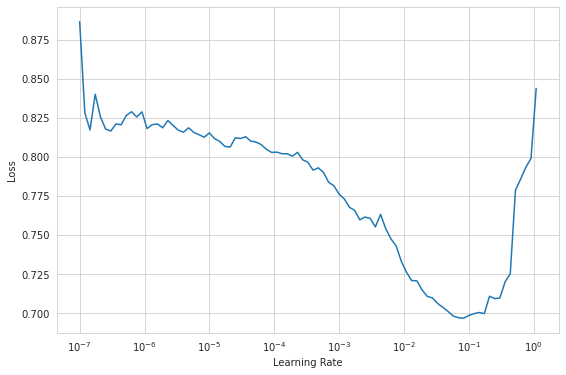

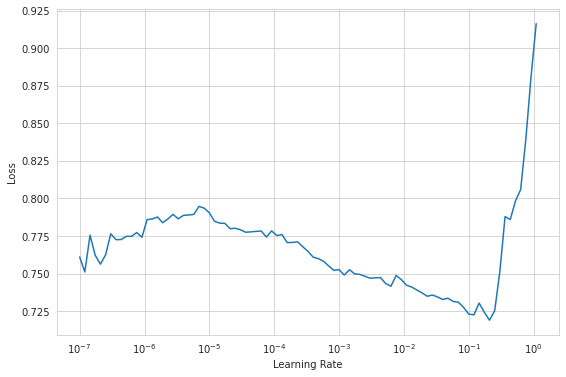

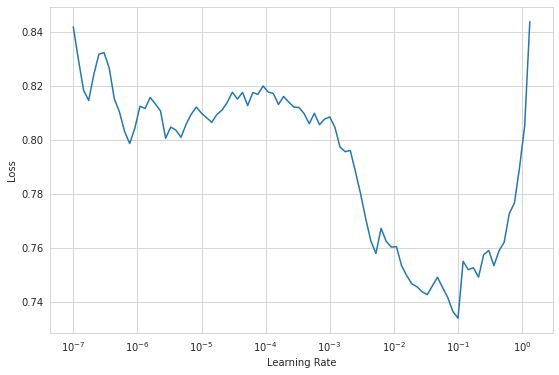

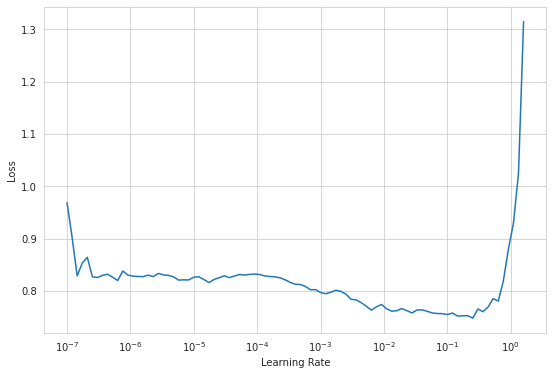

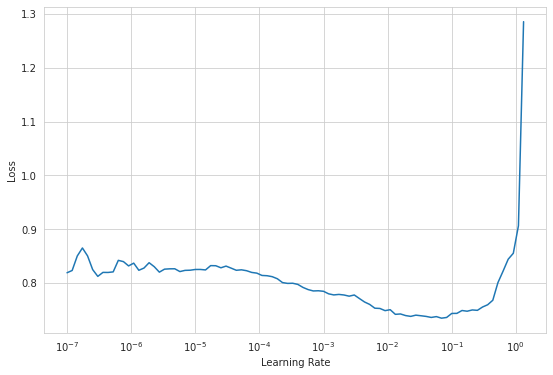

In [81]:
%%time
eval_d = {}
for idx, y_label in enumerate(STANDARD_THEME_SAW_LABELS):
    print(f'=== {y_label} - BEGIN ===')
    eval_d[y_label] = {}
    
    # normal LTR text
    model_name, valid_loss, scores, probs, targs, losses = train_saw_themes_multiclass(y_label, 
                                                                                       reverse_text=False, 
                                                                                       use_weighted_loss=True)
    
    eval_d[y_label]['fwd'] = dict(zip(['model_name', 'valid_loss', 'scores', 'probs', 'targs', 'losses'],
                                      [model_name, valid_loss, scores, probs, targs, losses]))
    
    # reverse text (RTL)
    model_name, valid_loss, scores, probs, targs, losses = train_saw_themes_multiclass(y_label, 
                                                                                       reverse_text=True, 
                                                                                       use_weighted_loss=True)
    
    eval_d[y_label]['bwd'] = dict(zip(['model_name', 'valid_loss', 'scores', 'probs', 'targs', 'losses'],
                                      [model_name, valid_loss, scores, probs, targs, losses]))
    
    print(f'=== {y_label} - DONE ===')
    
print(eval_d)

In [63]:
# multiclass_training_results

In [400]:
# save results
# with open(STANDARD_THEME_SAW_PATH/'models/multiclass_training_results.pkl', 'wb') as f:
#     pickle.dump(eval_d, f)

In [64]:
# load results
with open(STANDARD_THEME_SAW_PATH/'models/multiclass_training_results.pkl', 'rb') as f:
    multiclass_training_results = pickle.load(f)

In [65]:
summary = []
for lbl,v in multiclass_training_results.items():
    for direction, results in v.items():
        summary.append({
            'label': lbl,
            'dir': direction,
            'accuracy': results['scores']['accuracy'],
            'balanced_accuracy_score': results['scores']['balanced_accuracy_score'],
            'average_precision_score': results['scores']['average_precision_score'],
            'roc_auc_score': results['scores']['roc_auc_score'],
            'f05': results['scores']['f05']['score'],
            'f1': results['scores']['f1']['score'],
            'f2': results['scores']['f2']['score'],
            'f05_threshold': results['scores']['f05']['threshold'],
            'f1_threshold': results['scores']['f1']['threshold'],
            'f2_threshold': results['scores']['f2']['threshold'],
            'pos_label_count': results['targs'].sum().item()
        })
        
    loss_fwd, loss_bwd = v['fwd']['valid_loss'], v['bwd']['valid_loss']
    probs_fwd, probs_bwd = v['fwd']['probs'][:,1], v['bwd']['probs'][:,1]
    
    loss_final = (loss_fwd + loss_bwd) / 2
    probs_final = (probs_fwd + probs_bwd) / 2
    targs = v['fwd']['targs']
    
    threshold_f05 = f05.opt_th(probs_final, targs)
    threshold_f1 = f1.opt_th(probs_final, targs)
    threshold_f2 = f2.opt_th(probs_final, targs)
    
    summary.append({
        'label': lbl,
        'dir': 'ensemble',
        'accuracy': accuracy_multi(probs_final, targs, threshold_f05, sigmoid=False).item(),
        'balanced_accuracy_score': bal_acc_metric((probs_final > threshold_f05).float(),targs),
        'average_precision_score': ap_score_metric(probs_final, targs),
        'roc_auc_score': results['scores']['roc_auc_score'],
        'f05': f05.opt_fscore(probs_final, targs),
        'f1': f1.opt_fscore(probs_final, targs),
        'f2': f2.opt_fscore(probs_final, targs),
        'f05_threshold': f05.opt_th(probs_final, targs),
        'f1_threshold': f1.opt_th(probs_final, targs),
        'f2_threshold': f2.opt_th(probs_final, targs),
        'pos_label_count': targs.sum().item()
    })
    

In [66]:
results_df = pd.DataFrame(summary)

In [82]:
results_df

,label,dir,accuracy,balanced_accuracy_score,average_precision_score,roc_auc_score,f05,f1,f2,f05_threshold,f1_threshold,f2_threshold,pos_label_count
0,adequate_staffing,fwd,0.794286,0.781087,0.578317,0.860480,0.493827,0.519481,0.600858,0.69,0.66,0.45,34
1,adequate_staffing,bwd,0.762857,0.816176,0.500973,0.877048,0.400000,0.480000,0.660793,0.69,0.55,0.55,34
2,adequate_staffing,ensemble,0.897143,0.733060,0.564321,0.877048,0.483871,0.506329,0.608696,0.69,0.67,0.47,34
3,advancement_and_training_opportunities,fwd,0.668571,0.695953,0.325509,0.791713,0.248344,0.326531,0.487805,0.65,0.63,0.63,22
4,advancement_and_training_opportunities,bwd,0.888571,0.834534,0.306625,0.911308,0.404040,0.484848,0.625000,0.56,0.56,0.42,22
5,advancement_and_training_opportunities,ensemble,0.905714,0.843681,0.323974,0.911308,0.420792,0.507463,0.639098,0.63,0.63,0.63,22
6,appropriate_stress_work_assigned_equitably,fwd,0.762857,0.691770,0.246063,0.806566,0.270270,0.336842,0.477273,0.59,0.59,0.43,28
7,appropriate_stress_work_assigned_equitably,bwd,0.717143,0.732143,0.228281,0.791593,0.250000,0.297872,0.473684,0.69,0.50,0.31,28
8,appropriate_stress_work_assigned_equitably,ensemble,0.837143,0.699534,0.256310,0.791593,0.284091,0.344828,0.519481,0.61,0.61,0.43,28
9,benefits,fwd,0.977143,0.771913,0.538718,0.916911,0.675676,0.625000,0.714286,0.65,0.65,0.19,9


In [70]:
results_df.to_csv(STANDARD_THEME_SAW_PATH/'models/multiclass_training_summary.csv', index=None)

## Ensemble forwards and backwards passes

In [ ]:
# save this information to be added to inference returned data
model_results = {
    'threshold_f05': threshold_f05,
    'threshold_f1': threshold_f1,
    'threshold_f2': threshold_f2,
    
    'val_acc_f05': val_acc_f05,
    'val_acc_f1': val_acc_f1,
    'val_acc_f2': val_acc_f2,
    'val_loss': final_valid_loss.item()
}

with open(STANDARD_THEME_SAW_PATH/'model_results.json', 'w') as f: json.dump(model_results, f)

### Inference (ad-hoc documents)

In [ ]:
print(STANDARD_THEME_SAW_LABELS)

In [ ]:
test_comments = [
    'The parking situation REALLY sucks around here.  It needs to be fixed',
    'I LOVE working at UCSD!!!  It is wonderful',
    """Some staff are just uninformed.There is no support for solo-individual study (no closed off rooms).
        Once a guy (quite tall) walked in into the girl's restroom and used the stalls standing up. 
        There was no line in the guy's restroom. This happened when I done and was going to walk out. 
        I was extremely uncomfortable""",
    "I love UCSD!!! It is a terrible place to work!",
    "I was really uncomfortable to express my opinion!!!"
]

for c in test_comments: print(learn_fwd.predict(c, with_input=True))

### Inference (batch ensemble)

In [ ]:
import datetime
yyyymmdd = datetime.date.today().strftime("%Y%m%d")

m_suf = '_multilabel'

# device = torch.device('cpu')
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

In [ ]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 212].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

corpus_cols = ['AnswerText']  # ['question_text', 'answer_text']

In [ ]:
def concat_pool(raw_outputs):
    last_rnn_layer = raw_outputs[:,-1,None] # (e.g. (bs,n_hid,emb_sz) => (bs,1,emb_sz)) 
    bsz = last_rnn_layer.shape[0] 
    
    avg_pool = F.adaptive_avg_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    max_pool = F.adaptive_max_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    last_outp = last_rnn_layer[:,-1,:]

    return torch.cat([last_outp, max_pool, avg_pool], 1)

In [ ]:
def get_theme_results(backwards:bool=False, m_suf:str='multilabel'):
    
    model_prefix = 'bwd' if backwards else 'fwd'
    
    # 1. grab learner, procs, and data
    inf_learn = load_learner(fname=STANDARD_THEME_SAW_PATH/f'{model_prefix}_export_clas_{m_suf}.pkl', cpu=False)
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    tok_inf_df, tok_counts = tokenize_df(inf_df, corpus_cols)
    inf_dl = inf_learn.dls.test_dl(tok_inf_df, rm_type_tfms=None, bs=128)
    if (backwards): inf_dl.tfms.add(Transform(lambda nums: nums.flip(0)))

    # 3. get probs and document vectors
    test_probs, doc_vecs, concat_doc_vecs = [], [], []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # reset hidden state (if you don't do this you will OOM)
            inf_learn.model.reset()
            
            # note: even though there is no targets, each batch is a tuple!
            probs, raw_outputs, outputs = inf_learn.model(b[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))
            doc_vecs.append(to_detach(raw_outputs[:,-1,:]))
            concat_doc_vecs.append(to_detach(concat_pool(raw_outputs)))

    all_probs = L(torch.cat(test_probs))
    all_vecs = L(torch.cat(doc_vecs))
    all_concat_vecs = L(torch.cat(concat_doc_vecs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
    all_vecs = all_vecs[0][np.argsort(inf_dl.get_idxs())]
    all_concat_vecs = all_concat_vecs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. return ordered results
    inf_learn, inf_data = None, None; gc.collect()
    
    return all_probs, all_vecs, all_concat_vecs

In [ ]:
%time

probs_fwd, vecs_fwd, concat_vecs_fwd = get_theme_results(backwards=False)
probs_bwd, vecs_bwd, concat_vecs_bwd = get_theme_results(backwards=True)

probs_final = torch.sigmoid((probs_fwd + probs_bwd) / 2)

print(probs_final.shape)
print(probs_fwd.shape, vecs_fwd.shape, concat_vecs_fwd.shape)
print(probs_bwd.shape, vecs_bwd.shape, concat_vecs_bwd.shape)

Add the probabilities of each label to `inf_df`

In [ ]:
prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_SAW_LABELS]
probs_df = pd.DataFrame(probs_final.numpy(), columns=prob_labels)
probs_df.head()

In [ ]:
# test_df_filtered.update(probs_df)
final_df = pd.concat([inf_df, probs_df], axis=1)

Add in predictions based on f1 threshold

In [ ]:
for lbl in STANDARD_THEME_SAW_LABELS:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > threshold_f1).astype(np.int64)

Include found thresholds

In [ ]:
final_df['threshold_f05'] = threshold_f05
final_df['threshold_f1'] = threshold_f1
final_df['threshold_f2'] = threshold_f2

final_df['val_acc_f05'] = val_acc_f05
final_df['val_acc_f1'] = val_acc_f1
final_df['val_acc_f2'] = val_acc_f2

final_df['val_loss'] = final_valid_loss

In [ ]:
final_df.head()

In [ ]:
final_df.AnswerText[final_df.Id == 589546].values

In [ ]:
import datetime
final_df.to_csv(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_ensemble_predictions{m_suf}.csv', index=False)

### Save document vectors

In [ ]:
%time 

np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_fwd_concat_docvecs_d400{m_suf}.npy'), concat_vecs_fwd.numpy())  
np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_fwd_docvecs_d400{m_suf}.npy'), vecs_fwd.numpy())

np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_bwd_concat_docvecs_d400{m_suf}.npy'), concat_vecs_bwd.numpy())  
np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_bwd_docvecs_d400{m_suf}.npy'), vecs_bwd.numpy())

### Playground

In [ ]:
final_df.iloc[0].threshold_f05, final_df.iloc[0].threshold_f1, final_df.iloc[0].threshold_f2